In [2]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### Load and double-check the images dataset

In [5]:
dataset_root = "../data/images"

classes = [
    d for d in sorted(os.listdir(dataset_root))
    if os.path.isdir(os.path.join(dataset_root, d)) and not d.startswith(".")
]

print("Number of classes:", len(classes))
print(classes)

Number of classes: 30
['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


In [6]:
rows = []

for cls in classes:
    for mode in ["default", "real_world"]:
        mode_path = os.path.join(dataset_root, cls, mode)
        png_files = [
            f for f in os.listdir(mode_path)
            if f.lower().endswith(".png")
        ]
        rows.append((cls, mode, len(png_files)))

df_counts = pd.DataFrame(rows, columns=["class", "mode", "count"])
df_counts.head()

,class,mode,count
0,aerosol_cans,default,250
1,aerosol_cans,real_world,250
2,aluminum_food_cans,default,250
3,aluminum_food_cans,real_world,250
4,aluminum_soda_cans,default,250


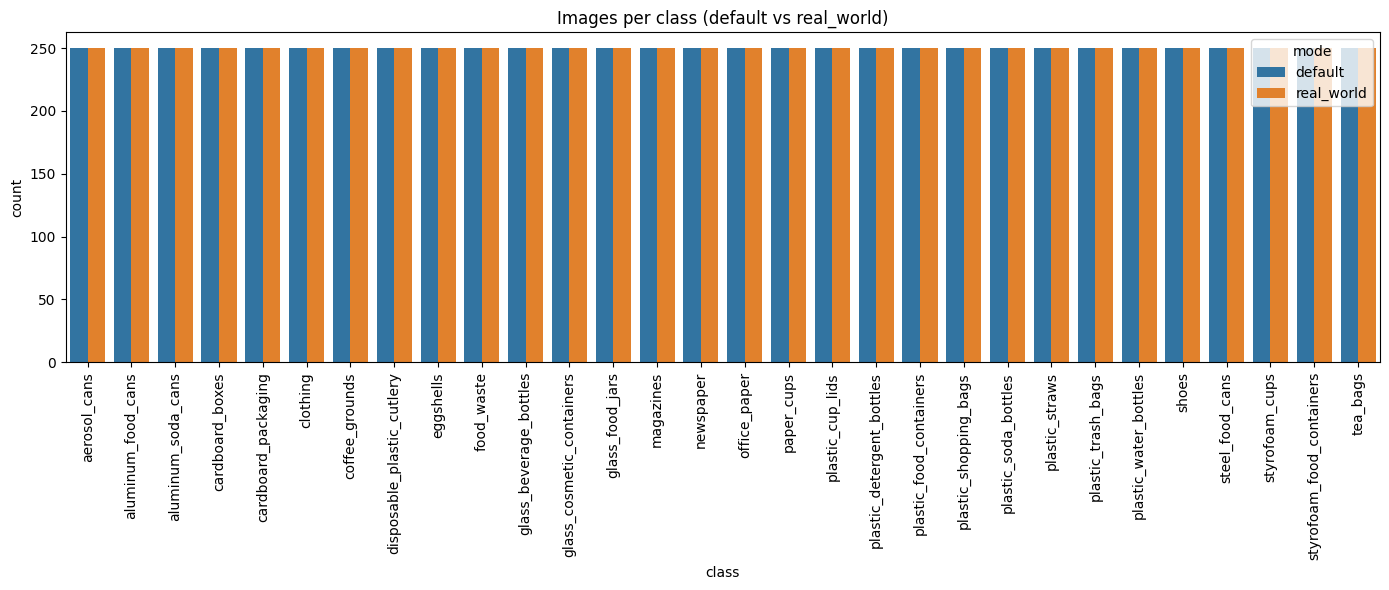

In [7]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_counts, x="class", y="count", hue="mode")
plt.xticks(rotation=90)
plt.title("Images per class (default vs real_world)")
plt.tight_layout()
plt.show()

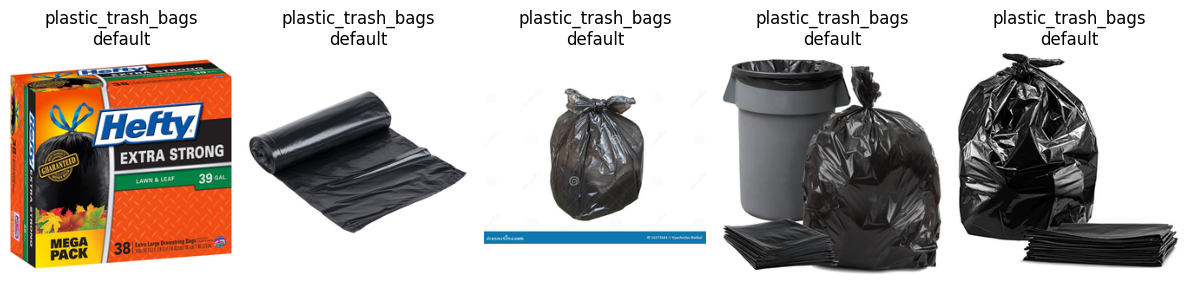

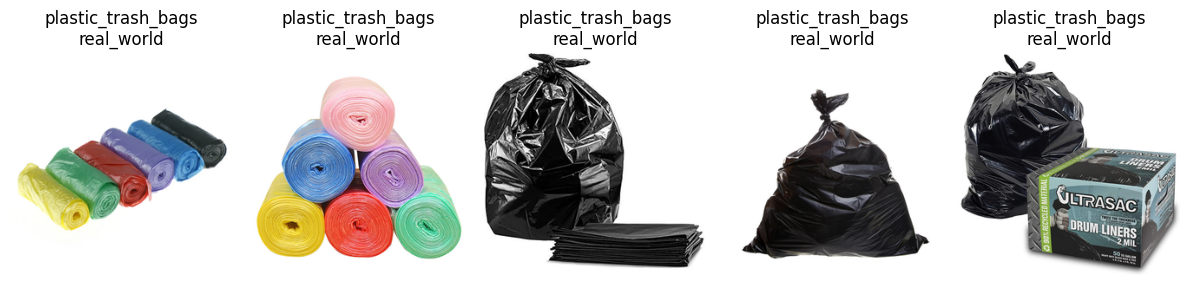

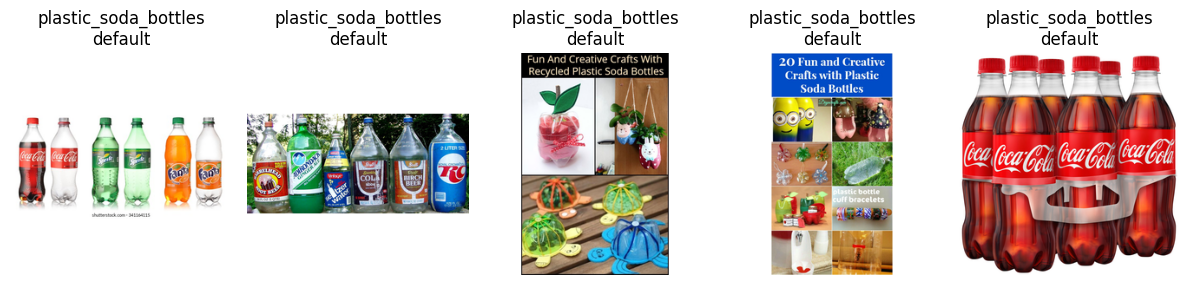

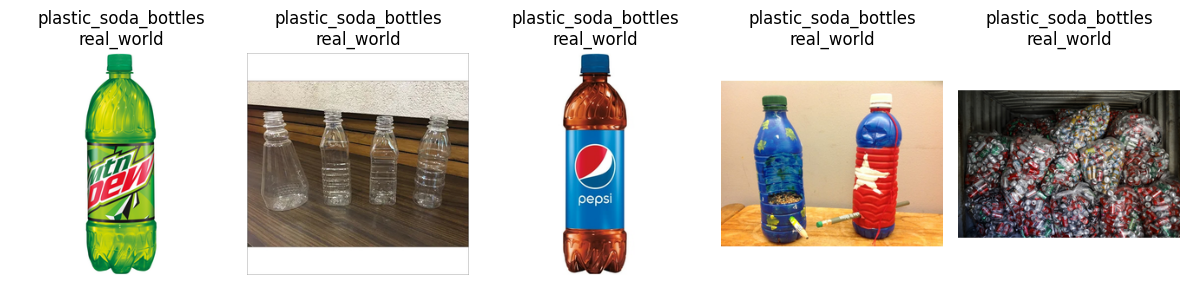

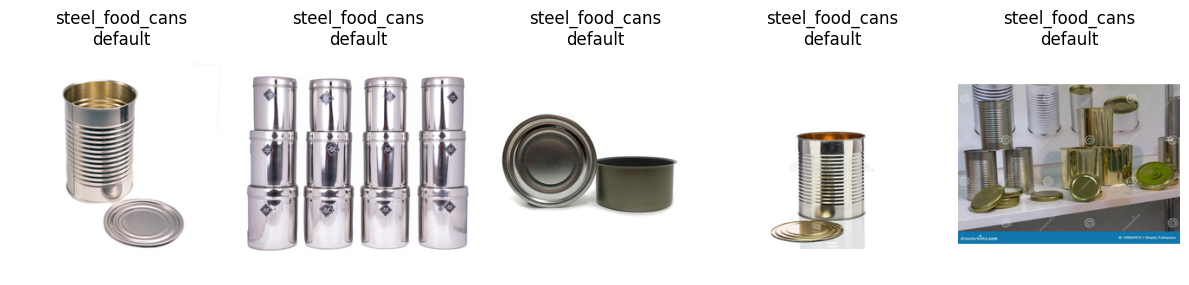

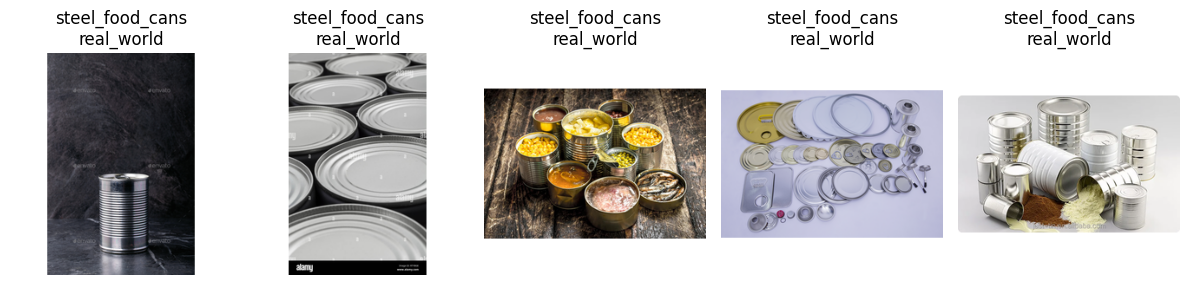

In [8]:
def show_examples(cls_name, mode="default", n=5):
    folder = os.path.join(dataset_root, cls_name, mode)
    imgs = [f for f in os.listdir(folder) if f.lower().endswith(".png")]
    imgs = random.sample(imgs, min(n, len(imgs)))

    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(imgs):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{cls_name}\n{mode}")
    plt.tight_layout()
    plt.show()

for cls in random.sample(classes, 3):
    show_examples(cls, mode="default", n=5)
    show_examples(cls, mode="real_world", n=5)

### Train the baseline model

In [9]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    directory=dataset_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    directory=dataset_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
print("num_classes:", num_classes)
print("class_indices:", class_indices)

Found 12000 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
num_classes: 30
class_indices: {'aerosol_cans': 0, 'aluminum_food_cans': 1, 'aluminum_soda_cans': 2, 'cardboard_boxes': 3, 'cardboard_packaging': 4, 'clothing': 5, 'coffee_grounds': 6, 'disposable_plastic_cutlery': 7, 'eggshells': 8, 'food_waste': 9, 'glass_beverage_bottles': 10, 'glass_cosmetic_containers': 11, 'glass_food_jars': 12, 'magazines': 13, 'newspaper': 14, 'office_paper': 15, 'paper_cups': 16, 'plastic_cup_lids': 17, 'plastic_detergent_bottles': 18, 'plastic_food_containers': 19, 'plastic_shopping_bags': 20, 'plastic_soda_bottles': 21, 'plastic_straws': 22, 'plastic_trash_bags': 23, 'plastic_water_bottles': 24, 'shoes': 25, 'steel_food_cans': 26, 'styrofoam_cups': 27, 'styrofoam_food_containers': 28, 'tea_bags': 29}


In [10]:
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze for initial training

inputs = Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

2025-12-03 13:26:19.508924: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-12-03 13:26:19.508960: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-12-03 13:26:19.508970: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 14.04 GB
2025-12-03 13:26:19.509003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 13:26:19.509018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 30)                38430     
                                                                 
Total params: 2296414 (8.76 MB)
Trainable params: 38430 (150.

#### Important: switch the optimizer from the default to legacy for Apple silicon

In [11]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

⚠️ This cell runs for 🕐 ~10 min on Mac with M3 chipset and 36Gb RAM

In [12]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    ModelCheckpoint("best_mobilenetv2.h5", monitor="val_loss",
                    save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10


2025-12-03 13:26:21.021438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-03 13:26:21.061455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


375/375 [==============================] - ETA: 0s - loss: 1.4118 - accuracy: 0.5923
Epoch 1: val_loss improved from inf to 0.74449, saving model to best_mobilenetv2.h5
375/375 [==============================] - 61s 161ms/step - loss: 1.4118 - accuracy: 0.5923 - val_loss: 0.7445 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 2/10


/Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/mini_projects/project-4-cv/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.7552
Epoch 2: val_loss improved from 0.74449 to 0.66315, saving model to best_mobilenetv2.h5
375/375 [==============================] - 61s 162ms/step - loss: 0.7983 - accuracy: 0.7552 - val_loss: 0.6631 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7880
Epoch 3: val_loss improved from 0.66315 to 0.58013, saving model to best_mobilenetv2.h5
375/375 [==============================] - 62s 164ms/step - loss: 0.6724 - accuracy: 0.7880 - val_loss: 0.5801 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.8067
Epoch 4: val_loss improved from 0.58013 to 0.53656, saving model to best_mobilenetv2.h5
375/375 [==============================] - 61s 163ms/step - loss: 0.6058 - accuracy: 0.8067 - val_loss: 0.5366 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 5/10
375/375

#### Fine-tune the model

Approach: unfreeze the upper layers.
Running this model on Mac/M3 makes the Jupyter Kernel crash. Do not run the commented code below!
⏭️ Abandoning fine-tuning, keep the frozen basemodel.

In [13]:
# base_model.trainable = True

# # fine-tune only the top N layers
# for layer in base_model.layers[:-40]:
#     layer.trainable = False

# model.compile(
#     optimizer=Adam(1e-5),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# history_ft = model.fit(
#     train_gen,
#     epochs=5,
#     validation_data=val_gen,
#     callbacks=callbacks
# )

### Plot training curves

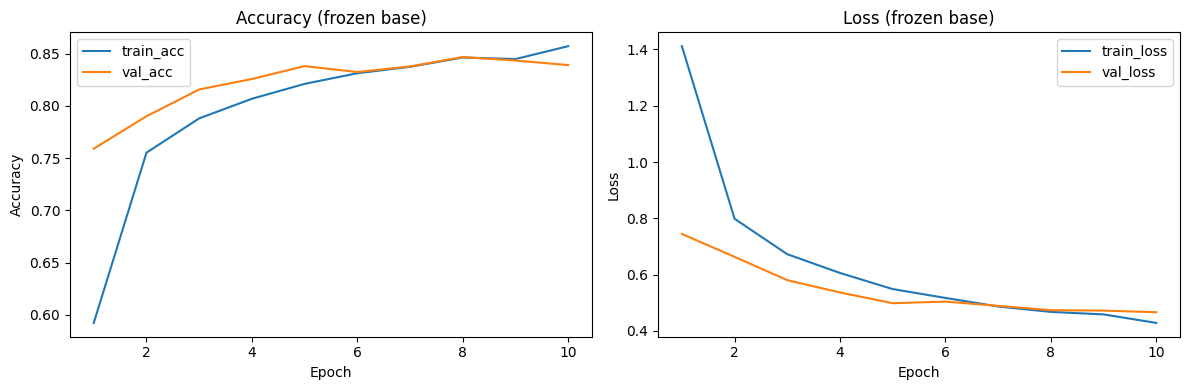

In [ ]:
def plot_history(h, title_suffix=""):
    acc = h.history["accuracy"]
    val_acc = h.history["val_accuracy"]
    loss = h.history["loss"]
    val_loss = h.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(f"Accuracy{title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(f"Loss{title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, " (frozen base)")